In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
import time

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

In [3]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [8]:
def Plot_img(images, labels, class_names, num_rows=2, num_cols=2):
    plt.figure(figsize=(num_cols * 2.5, num_rows * 2.5))  # Adjust figure size based on grid size
    
    labels = labels.flatten()
    
    num_images = num_rows * num_cols
    indices = []
    for j in range(len(class_names)):
        if len(indices) >= num_images:
            break
        for i in range(len(labels)):
            if labels[i] == j:
                indices.append(i)
                break
    if len(indices) < num_images:
        print(f"Warning: Only {len(indices)} images available for the specified number of classes.")
        num_rows = len(indices) // num_cols + (len(indices) % num_cols > 0)
    
    for i in range(num_images):
        if i < len(indices):
            ax = plt.subplot(num_rows, num_cols, i + 1)
            plt.imshow(images[indices[i]])
            plt.title(class_names[labels[indices[i]]])
            plt.axis("off")
        else:
            plt.subplot(num_rows, num_cols, i + 1)
            plt.axis("off")  # Turn off axis for empty plots

    plt.tight_layout()
    plt.show()

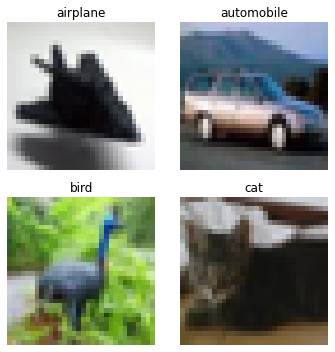

In [9]:
Plot_img(train_images, train_labels, class_names)

In [6]:
train_images = train_images.astype(np.float32)
train_images = (train_images - 127.5) / 127.5

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Generator

In [10]:
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(4*4*1024, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((4, 4, 1024)),

        layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    assert model.output_shape == (None, 64, 64, 3)
    return model

In [11]:
generator = make_generator_model()

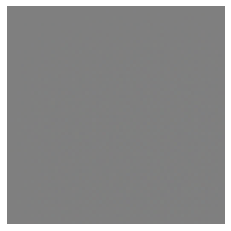

In [12]:
generator = make_generator_model()
noise = tf.random.normal([1, 100])  
generated_image = generator(noise, training=False)
normalized_image = (generated_image[0] + 1) / 2

plt.imshow(normalized_image)
plt.axis('off')
plt.show()

# Discriminator

In [14]:
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(1024, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)

# Define the loss and optimizers

In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Discriminator loss

In [18]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Generator loss

In [19]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [20]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Define the training loop

In [21]:
EPOCHS = 350
noise_dim = 100
num_examples_to_generate = 32
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [22]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      images = tf.image.resize(images, [64, 64])

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Generate and save images

In [23]:
def calculate_diversity(images):
    images_flat = images.reshape(images.shape[0], -1)
    pixel_std = np.std(images_flat, axis=0).mean()
    return pixel_std

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    predictions = (predictions + 1) / 2  

    diversity_score = calculate_diversity(predictions.numpy()) 
    print(f"Diversity score at epoch {epoch}: {diversity_score}\n")

    fig = plt.figure(figsize=(10, 10))
    num_images = min(predictions.shape[0], 32)
    for i in range(num_images):
        ax = plt.subplot(8, 4, i + 1)
        ax.imshow(predictions[i])
        ax.axis('off')

    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()


In [24]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    print(f"Epoch {epoch+1}/{epochs} completed.")

In [ ]:
train(train_dataset, EPOCHS)

Diversity score at epoch 350: 0.2026023417711258



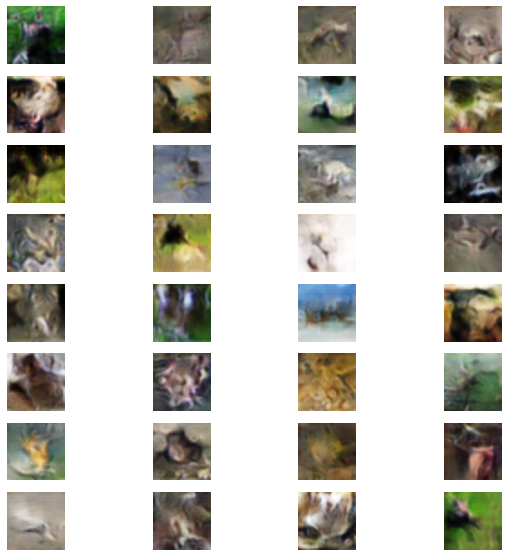

In [ ]:
generate_and_save_images(generator, 350, seed)